In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"

from matplotlib import pyplot as plt

import torch
from gsplat import project_gaussians
from gsplat.rasterize import rasterize_gaussians

from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# load model and dataset
model, renderer = GaussianModelLoader.search_and_load(
    "../outputs/garden/down_sample_4/",
    sh_degree=3,
    device="cuda",
)
print("Gaussian count: {}".format(model.get_xyz.shape[0]))
# dataset
dataparser_outputs = ColmapDataParser(
    os.path.expanduser("~/data/Mip-NeRF360/garden"),
    os.path.abspath(""),
    global_rank=0,
    params=ColmapParams(
        split_mode="experiment",
        reorient=True,
        down_sample_factor=4,
    ),
).get_outputs()
print("Test camera count: {}".format(len(dataparser_outputs.test_set.cameras)))

Gaussian count: 6023959
appearance group by camera id
loading colmap 3D points
down sample enabled
reorient scene
up vector = [-0.00169421 -0.8823425  -0.4706047 ]
reorienting cameras...
reorienting points...
[colmap dataparser] train set images: 161, val set images: 24, loaded mask: 0
Test camera count: 24


In [3]:
# pick a camera
camera = dataparser_outputs.test_set.cameras[0].to_device("cuda")
camera

Camera(R=tensor([[ 9.9992e-01, -5.9221e-04, -1.2980e-02],
        [-1.2848e-02, -1.9392e-01, -9.8093e-01],
        [-1.9361e-03,  9.8102e-01, -1.9391e-01]], device='cuda:0'), T=tensor([-0.3283, -1.9260,  3.9581], device='cuda:0'), fx=tensor(961.4100, device='cuda:0'), fy=tensor(962.8025, device='cuda:0'), fov_x=tensor(1.1869, device='cuda:0'), fov_y=tensor(0.8227, device='cuda:0'), cx=tensor(648.5000, device='cuda:0'), cy=tensor(420., device='cuda:0'), width=tensor(1297, device='cuda:0', dtype=torch.int16), height=tensor(840, device='cuda:0', dtype=torch.int16), appearance_id=tensor(0, device='cuda:0', dtype=torch.int32), normalized_appearance_id=tensor(0., device='cuda:0'), time=tensor(0., device='cuda:0'), distortion_params=tensor([0., 0., 0., 0.], device='cuda:0'), camera_type=tensor(0, device='cuda:0', dtype=torch.int8), world_to_camera=tensor([[ 9.9992e-01, -1.2848e-02, -1.9361e-03,  0.0000e+00],
        [-5.9221e-04, -1.9392e-01,  9.8102e-01,  0.0000e+00],
        [-1.2980e-02, -

In [4]:
import math
def projection_matrix(znear, zfar, fovx, fovy, device):
    """
    Constructs an OpenGL-style perspective projection matrix.
    """
    t = znear * math.tan(0.5 * fovy)
    b = -t
    r = znear * math.tan(0.5 * fovx)
    l = -r
    n = znear
    f = zfar
    return torch.tensor(
        [
            [2 * n / (r - l), 0.0, (r + l) / (r - l), 0.0],
            [0.0, 2 * n / (t - b), (t + b) / (t - b), 0.0],
            [0.0, 0.0, (f + n) / (f - n), -1.0 * f * n / (f - n)],
            [0.0, 0.0, 1.0, 0.0],
        ],
        device=device,
    )
projmat = projection_matrix(0.001, 1000, camera.fov_x, camera.fov_y, device=camera.world_to_camera.device)

In [5]:
xys, depths, radii, conics, comp, num_tiles_hit, cov3d = project_gaussians(  # type: ignore
    model.get_xyz,
    model.get_scaling,
    1,
    model.get_rotation / model.get_rotation.norm(dim=-1, keepdim=True),
    camera.world_to_camera.T[:3, :],
    projmat @ camera.world_to_camera.T,
    camera.fx.item(),
    camera.fy.item(),
    camera.cx.item(),
    camera.cy.item(),
    int(camera.height.item()),
    int(camera.width.item()),
    16,
)  # type: ignore

In [6]:
xys[num_tiles_hit > 0], conics[num_tiles_hit > 0], radii[num_tiles_hit > 0]

(tensor([[ 622.1341,  351.8106],
         [ 699.5034,  493.6202],
         [ 595.8589,  537.6223],
         ...,
         [ 921.2404,   29.5710],
         [1281.9579,   94.1520],
         [   3.2838,   56.8192]], device='cuda:0'),
 tensor([[ 1.1229,  0.1408,  1.5783],
         [ 0.1185, -0.0891,  0.7497],
         [ 1.0051, -0.1226,  3.2132],
         ...,
         [ 1.1449, -0.1742,  0.1986],
         [ 2.7624,  1.1955,  0.8003],
         [ 0.1876, -0.1397,  0.3591]], device='cuda:0'),
 tensor([ 4, 10,  4,  ...,  8,  7, 10], device='cuda:0', dtype=torch.int32))

In [7]:
depths[num_tiles_hit > 0]

tensor([ 4.4979,  7.4471,  6.5014,  ..., 32.0155, 30.6419, 12.5892],
       device='cuda:0')

In [8]:
num_tiles_hit[num_tiles_hit > 0]

tensor([4, 4, 2,  ..., 4, 4, 3], device='cuda:0', dtype=torch.int32)

In [9]:
# compute color
from internal.utils.sh_utils import eval_sh

means = model.get_xyz
features = model.get_features
shs_view = features.transpose(1, 2).view(-1, 3, (model.max_sh_degree + 1) ** 2)
dir_pp = (means - camera.camera_center.repeat(features.shape[0], 1))
dir_pp_normalized = dir_pp / dir_pp.norm(dim=1, keepdim=True)
sh2rgb = eval_sh(model.active_sh_degree, shs_view, dir_pp_normalized)
colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
colors_precomp

tensor([[0.0616, 0.1495, 0.0000],
        [0.5431, 0.4917, 0.4314],
        [0.6522, 0.6197, 0.4449],
        ...,
        [0.2620, 0.3721, 0.0632],
        [1.4145, 1.3634, 1.2117],
        [0.6196, 0.5612, 0.4686]], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


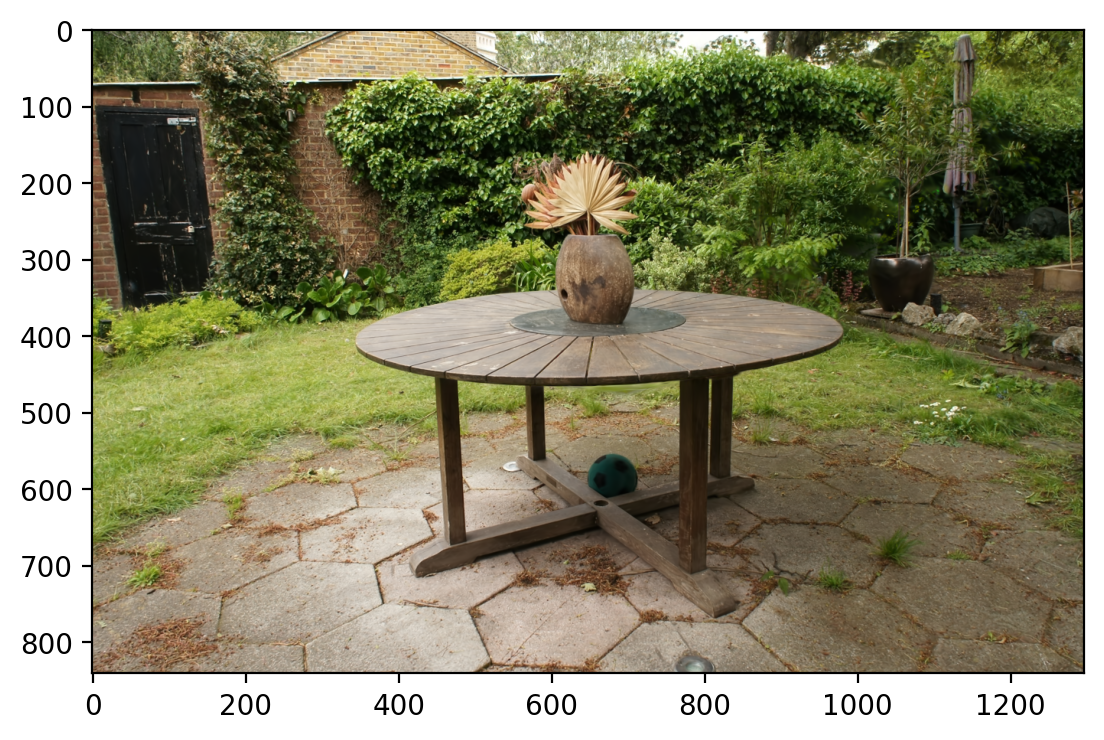

In [10]:
rgb, alpha = rasterize_gaussians(  # type: ignore
    xys,
    depths,
    radii,
    conics,
    num_tiles_hit,  # type: ignore
    colors_precomp,
    model.get_opacity,
    int(camera.height.item()),
    int(camera.width.item()),
    16,
    background=torch.tensor([0., 0., 0.], dtype=torch.float, device=xys.device),
    return_alpha=True,
)  # type: ignore
plt.imshow(rgb.cpu().numpy())
plt.show()